### Install Waymo Open Dataset

In [1]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

Cloning into 'waymo-od'...
remote: Enumerating objects: 1262, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 1262 (delta 214), reused 255 (delta 128), pack-reused 884
Receiving objects: 100% (1262/1262), 26.00 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (794/794), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/om2
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
Note: checking out 'remotes/origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now

In [2]:
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0

     |████████████████████████████████| 2.8 MB 5.4 MB/s            
     |████████████████████████████████| 421.8 MB 5.7 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 50 kB 6.8 MB/s             
     |████████████████████████████████| 448 kB 49.3 MB/s            
     |████████████████████████████████| 3.8 MB 45.5 MB/s            
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=64f05f30de215dd04a71b0e60a03c8030ce170a48cd78f7b5b664143cc70a8da
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      S

### Convert '.tfrecord' into '.jpg' and '.txt'

In [4]:
import os
import math
#import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import progressbar

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

In [ ]:
############################Config###########################################
# path to waymo dataset "folder" (all .tfrecord files in that folder will be converted)
DATA_PATH = '/content/drive/MyDrive/waymo_train_dataset'
# path to save kitti dataset
YOLOv5_PATH = '/content/drive/MyDrive/yolov5_train_dataset'
# location filter, use this to convert your preferred location
LOCATION_FILTER = True
LOCATION_NAME = ['location_sf']
# max indexing length
INDEX_LENGTH = 15
# as name
IMAGE_FORMAT = 'jpg'
# do not change
LABEL_PATH = YOLOv5_PATH + '/label_'
IMAGE_PATH = YOLOv5_PATH + '/image_'
###############################################################################

class Adapter:
    def __init__(self):
        self.__lidar_list = ['_FRONT', '_FRONT_RIGHT', '_FRONT_LEFT', '_SIDE_RIGHT', '_SIDE_LEFT']
        self.__type_list = ['VEHICLE', 'PEDESTRIAN', 'CYCLIST']

        self.get_file_names()
        self.create_folder()

    def cvt(self):
        # convert dataset from Waymo to YOLOvs format
        bar = progressbar.ProgressBar(maxval=len(self.__file_names)+1,
                    widgets= [progressbar.Percentage(), ' ',
                    progressbar.Bar(marker='>',left='[',right=']'),' ',
                    progressbar.ETA()])

        file_num = 1
        frame_num = 0
        print("start converting ...")
        bar.start()
        for file_name in self.__file_names:
            dataset = tf.data.TFRecordDataset(file_name, compression_type='')
            for data in dataset:
                frame = open_dataset.Frame()
                frame.ParseFromString(bytearray(data.numpy()))
                if LOCATION_FILTER == True and frame.context.stats.location not in LOCATION_NAME:
                    continue

                # save the image:
                self.save_image(frame, frame_num)

                # parse label
                self.save_label(frame, frame_num)

                frame_num += 1
            bar.update(file_num)
            file_num += 1
        bar.finish()
        print("\nfinished ...")

    def save_image(self, frame, frame_num):
        # parse and save the images in jpg format
        for img in frame.images:
            img_path = IMAGE_PATH + str(img.name - 1) + '/' + str(frame_num).zfill(INDEX_LENGTH) + '.' + IMAGE_FORMAT
            img = cv2.imdecode(np.frombuffer(img.image, np.uint8), cv2.IMREAD_COLOR)
            rgb_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            plt.imsave(img_path, rgb_img, format=IMAGE_FORMAT)

    def save_label(self, frame, frame_num):
        """ parse and save the label data in .txt format
                :param frame: open dataset frame proto
                :param frame_num: the current frame number
                :return:
                """
        for labels in frame.camera_labels:
            name = labels.name - 1
            width = 1920
            # the image size of front, frontleft and frontright camera is 1920x1280
            if name<=2: height = 1280
            # the image size of sideleft and sideright camera is 1920x886
            else: height = 886
            for label in labels.labels:
              # save the labels
              line = str(label.type) + ' {} {} {} {}\n'.format(round(label.box.center_x/width, 5),
                                                               round(label.box.center_y/height, 5),
                                                               round(label.box.length/width, 5),
                                                               round(label.box.width/height, 5))
              # store the label
              fp_label = open(LABEL_PATH + str(name) + '/' + str(frame_num).zfill(INDEX_LENGTH) + '.txt', 'a')
              fp_label.write(line)
              fp_label.close()

    def get_file_names(self):
        self.__file_names = []
        for i in os.listdir(DATA_PATH):
            if i.split('.')[-1] == 'tfrecord':
                self.__file_names.append(DATA_PATH + '/' + i)

    def create_folder(self):
        if not os.path.exists(YOLOv5_PATH):
            os.mkdir(YOLOv5_PATH)
        for i in range(5):
            if not os.path.exists(IMAGE_PATH + str(i)):
                os.mkdir(IMAGE_PATH + str(i))
            if not os.path.exists(LABEL_PATH + str(i)):
                os.mkdir(LABEL_PATH + str(i))

if __name__ == '__main__':
    adapter = Adapter()
    adapter.cvt()

N/A% [                                                         ] ETA:  --:--:--

start converting ...


100% [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] Time:  0:04:35



finished ...


### Install YOLOv5

In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-152-g26f0415 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.7/78.2 GB disk)


### Display image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

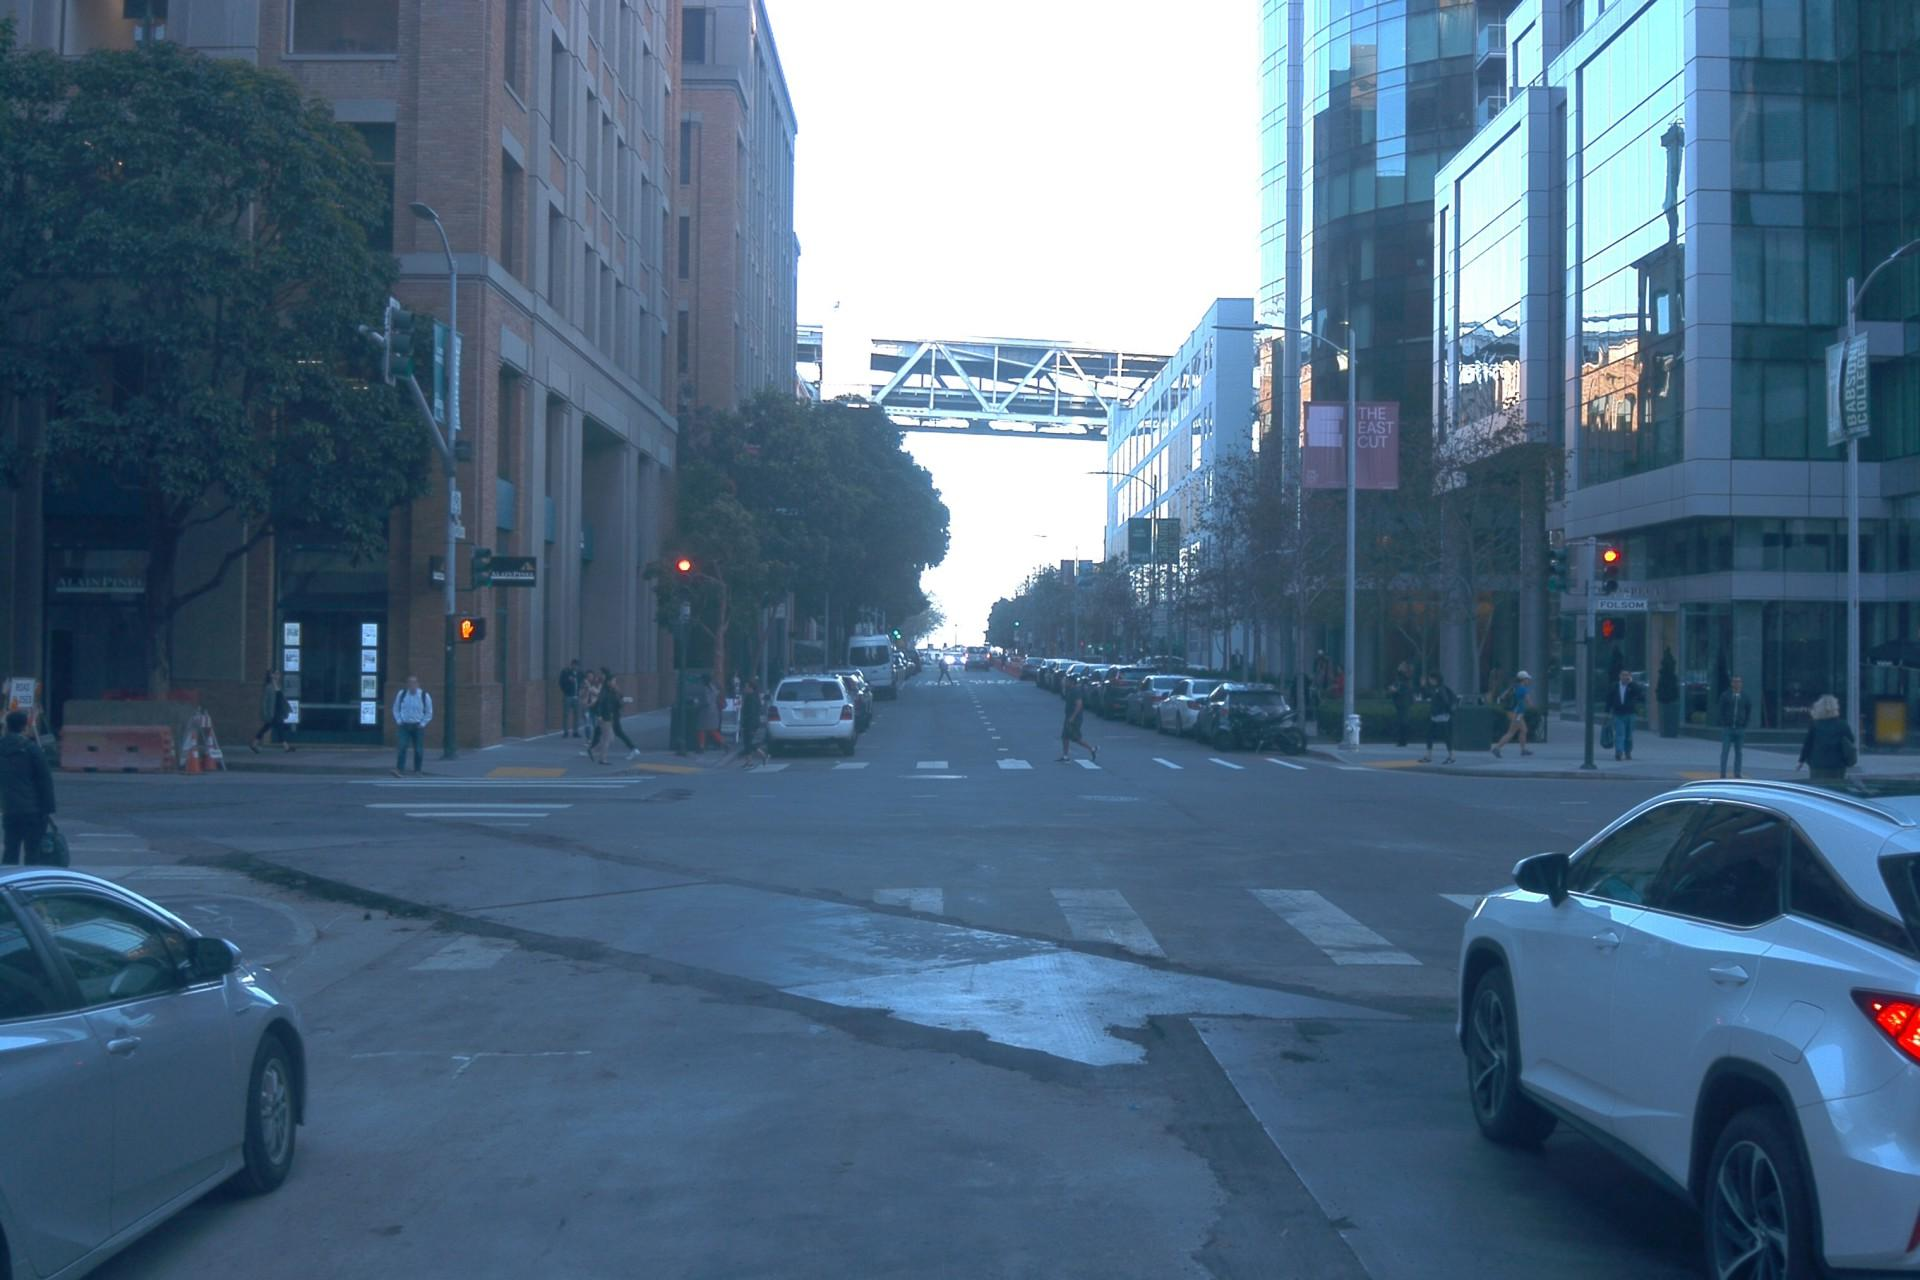

In [9]:
display.Image(filename='/content/drive/MyDrive/yolov5_train_dataset/image_0/000000000000000.jpg', width=600)

### Train on custom data

In [ ]:
!python train.py --img 640 --batch 16 --epochs 3 --data /content/drive/MyDrive/YOLOv5.yml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/YOLOv5.yml, hyp=data/hyps/hyp.scratch.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-103-g7a39803 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate

In [ ]:
!python train.py --img 640 --batch 16 --epochs 10 --data /content/drive/MyDrive/YOLOv5.yml --weights /content/yolov5/runs/train/exp/weights/best.pt

train: weights=/content/yolov5/runs/train/exp/weights/best.pt, cfg=, data=/content/drive/MyDrive/YOLOv5.yml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-103-g7a39803 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
!python train.py --img 640 --batch 16 --epochs 17 --data /content/drive/MyDrive/YOLOv5.yml --weights /content/yolov5/runs/train/exp2/weights/best.pt

train: weights=/content/yolov5/runs/train/exp2/weights/best.pt, cfg=, data=/content/drive/MyDrive/YOLOv5.yml, hyp=data/hyps/hyp.scratch.yaml, epochs=17, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-103-g7a39803 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

In [ ]:
!python train.py --img 640 --batch 16 --epochs 10 --data /content/drive/MyDrive/YOLOv5.yml --weights /content/yolov5/runs/train/exp3/weights/best.pt

train: weights=/content/yolov5/runs/train/exp3/weights/best.pt, cfg=, data=/content/drive/MyDrive/YOLOv5.yml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-103-g7a39803 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

### Run the best.pt

In [10]:
!python detect.py --weights /content/drive/MyDrive/best_40_epoch.pt --img 640 --conf 0.4 --source /content/drive/MyDrive/yolov5_train_dataset/image_0/000000000000000.jpg

detect: weights=['/content/drive/MyDrive/best_40_epoch.pt'], source=/content/drive/MyDrive/yolov5_train_dataset/image_0/000000000000000.jpg, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-152-g26f0415 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/yolov5_train_dataset/image_0/000000000000000.jpg: 448x640 11 vehicless, 18 pedestrianss, Done. (0.030s)
Speed: 0.6ms pre-process, 29.9ms inference, 45.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


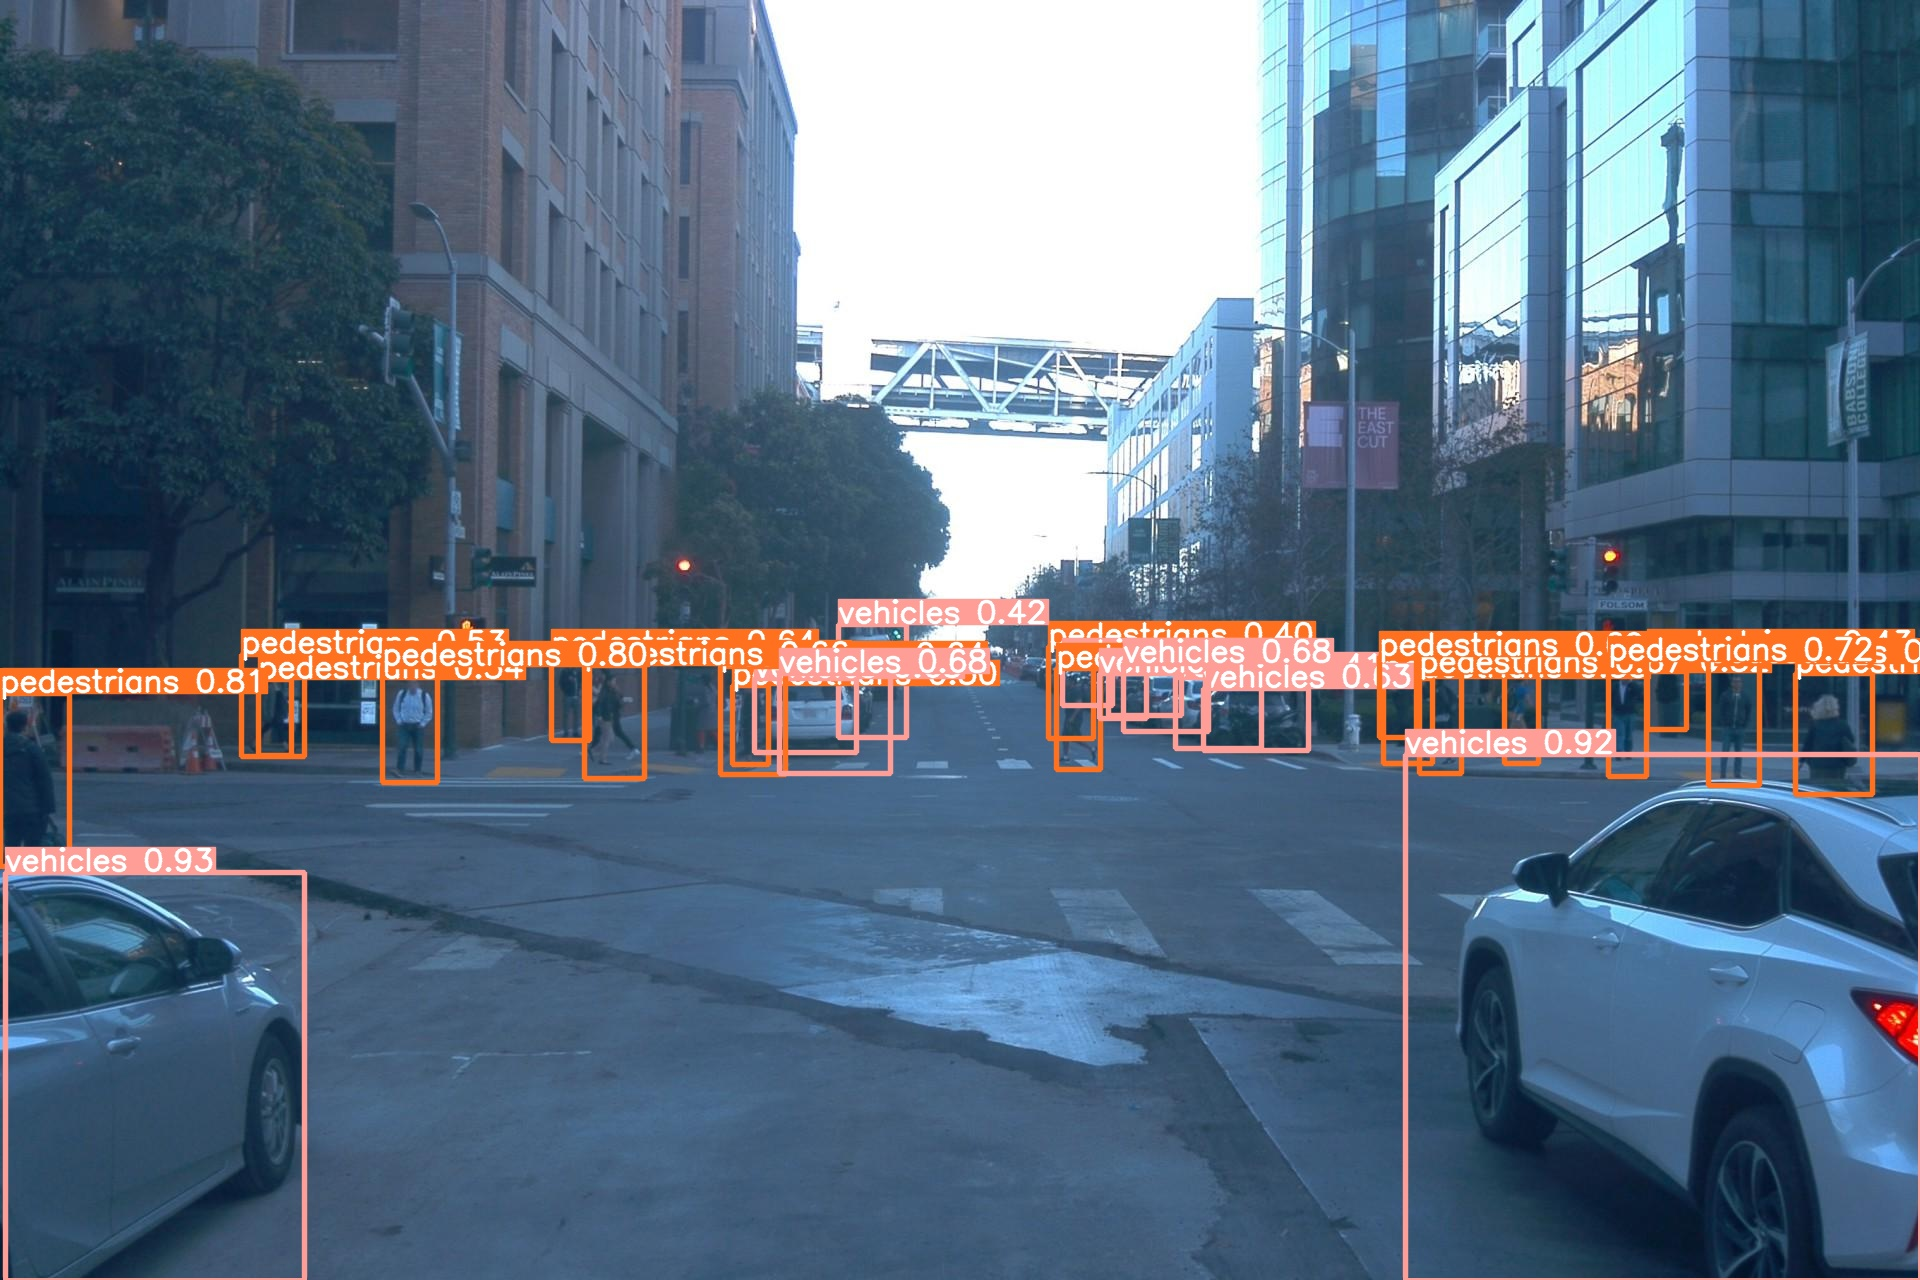

In [11]:
display.Image(filename='/content/yolov5/runs/detect/exp/000000000000000.jpg', width=600)

### Video

In [18]:
!python detect.py --weights /content/drive/MyDrive/best_40_epoch.pt --conf 0.6 --source '/content/drive/MyDrive/DRIVING IN KABUL CITY.mp4'

detect: weights=['/content/drive/MyDrive/best_40_epoch.pt'], source=/content/drive/MyDrive/DRIVING IN KABUL CITY.mp4, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-152-g26f0415 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/4973) /content/drive/MyDrive/DRIVING IN KABUL CITY.mp4: 384x640 2 vehicless, 2 pedestrianss, Done. (0.029s)
video 1/1 (2/4973) /content/drive/MyDrive/DRIVING IN KABUL CITY.mp4: 384x640 2 vehicless, 2 pedestrianss, Done. (0.027s)
video 1/1 (3/4973) /content/drive/MyDrive/DRIVING IN KABUL CITY.mp4: 384x640 3 vehicless, 2 pedestrianss, Done. (0.027